# Shape similarity identification with siamese network

In same cases only few samples of training data are available, which makes the training of a machinel mearning model difficult. The siamese network architecture provides a computationally reasonable way to check the similarity of sample pairs. Can be used to check the similarity of two imput images.

This implementation provides an example to test this concept, after the model is trained a reference imange is taken and compared with n sample of images, showing similarity in between. 

Author: fvilmos

Steps:
1. Create a toy database, generate different shapes pairs
    label logic: 1 - similar shapes ; 0 - different shapes
2. Visualize data
3. Create the siamese model
4. Test similarity with the reference image

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import cv2

import os
import glob

USE_GPU = 1

if USE_GPU == 1:    
    configproto = tf.compat.v1.ConfigProto() 
    configproto.gpu_options.allow_growth = True
    sess = tf.compat.v1.Session(config=configproto) 
    tf.compat.v1.keras.backend.set_session(sess)

    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    config = tf.compat.v1.ConfigProto(allow_soft_placement=True)

    config.gpu_options.per_process_gpu_memory_fraction = 0.3
    tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))
else:
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"  

Num GPUs Available:  1


## Create a toy database

- Input is a pair of images (128x128x3)
- n samples are generated (rectangles/circles, triangles with different size, colors)
- background noice added to increase the detection difficulty

In [2]:
BATCH_SIZE = 8
samples = 10000
w,h = 128,128
obj_min_size = 15
obj_max_size = 70
nr_shape_type = 3
nr_shape_color = 6
stype_lab = ['circle','rectangle', 'triangle']
scolor_lab = ['Red','Green','Blue','Yellow','Pink', 'Cyan']
colors = [[255,0,0],[0,255,0],[0,0,255],[255,255,0],[255,0,255],[0,255,255]]

In [3]:
# generate blur on the images
def generate_blur(img, iw=128,ih=128):
    """
    generate a blury background for an image
    """
    samples = (np.random.random(size=(iw,ih,3)) *1000).astype(np.ubyte)
    b_kernel = np.dot(np.random.choice([3,5,7,9,11,13,17]),np.array([1,1]))

    samples = cv2.blur(samples,tuple(b_kernel))
    img +=samples
    
    return img


def generate_img_with_shape(img, shape_type=0, color=(0,255,0), img_shape=(128,128), obj_size=(30,60)):
    """
    generate an image with a shape type
    0 - circle, 1 - retangle , 2 - triangle
    """

    ow = np.random.randint(obj_size[0],obj_size[1],dtype=np.uint8)
    oh = np.random.randint(obj_size[0],obj_size[1],dtype=np.uint8)
    oposx = np.random.randint(int(ow/2),img_shape[0]-ow,dtype=np.uint8)
    oposy = np.random.randint(int(oh/2),img_shape[1]-oh,dtype=np.uint8)

    if shape_type == 0:
        r = int(min(ow/2,oh/2))
        cv2.circle(img,(oposx,oposy),r,color,-1)
    elif shape_type == 1:
        cv2.rectangle(img,(oposx,oposy),(oposx+ow,oposy+oh),color,-1)
    elif shape_type == 2:
        triangle_points= np.array([[oposx,oposy],[oposx+ow,oposy],[oposx,oposy+oh]],dtype=np.int32)
        cv2.drawContours(img, [triangle_points], 0, color, -1)
        flipc = np.random.randint(-2,2,dtype=np.int8)
        img = cv2.flip(img,flipc)
    return img



def gen_traning_data(samples_nr=1000, iw=128,ih=128,obj_min=30,obj_max=60):
    """ generate traning data - rectangles with different size, return img and position"""
    
    imgsl = np.zeros((samples_nr,iw,ih,3),dtype=np.uint8)
    imgsr = np.zeros((samples_nr,iw,ih,3),dtype=np.uint8)
    img_labels = np.zeros((samples_nr,1),dtype=np.uint8)
 
    # generate random samples
    for i in range (samples_nr):

        samplesl = np.zeros(shape=(iw,ih,3),dtype=np.uint8)
        samplesr = np.zeros(shape=(iw,ih,3),dtype=np.uint8)
        
        imgsl[i] += generate_blur(samplesl, iw,ih)
        imgsr[i] += generate_blur(samplesr, iw,ih)

        # decide label type (similar of different)
        img_label = np.random.randint(0,2,dtype=np.uint8)
        img_labels[i] = img_label
        
        if img_label == 1:
            # generate similar images
            shape_type = np.random.randint(0,3,dtype=np.uint8)

            # generate random between [0,5]
            clord = np.random.randint(0,6,dtype=np.uint8)
            color = colors[clord]

            imgsl[i] = generate_img_with_shape(imgsl[i],shape_type=shape_type, color=color)
            
            # generate random between [0,5]
            clord = np.random.randint(0,6,dtype=np.uint8)
            color = colors[clord]
            
            imgsr[i] = generate_img_with_shape(imgsr[i],shape_type=shape_type, color=color)
            

        else:
            # genrate non similar images
            shape_type1 = 0
            shape_type2 = 0
            
            # ensure to have different shape types
            while True:
                shape_type1 = np.random.randint(0,3,dtype=np.uint8)
                shape_type2 = np.random.randint(0,3,dtype=np.uint8)
                if shape_type1 != shape_type2:
                    break
            
            # generate random between [0,5]
            clord = np.random.randint(0,6,dtype=np.uint8)
            color = colors[clord]

            imgsl[i] = generate_img_with_shape(imgsl[i],shape_type=shape_type1, color=color)
            
            # generate random between [0,5]
            clord = np.random.randint(0,6,dtype=np.uint8)
            color = colors[clord]
            
            imgsr[i] = generate_img_with_shape(imgsr[i],shape_type=shape_type2, color=color)

    return imgsl, imgsr, img_labels


In [4]:
class DataLoader(keras.utils.Sequence):
    def __init__(self, batch_size, sample_nr=1000, img_size=(128,128,3), obj_min=15, obj_max=75):
        self.batch_size = batch_size
        self.sample_nr=sample_nr
        self.img_size=img_size
        self.obj_max = obj_max
        self.obj_min = obj_min
    
    def __len__(self):
        return self.sample_nr//self.batch_size
    
    def __getitem__(self, indx):
        # simplified version, generates random samples by every call
        imgsl,imgsr,labels = gen_traning_data(samples_nr= self.batch_size,iw=self.img_size[0],ih=self.img_size[1],obj_min=self.obj_min,obj_max=self.obj_max)
        
        return {'left_in':imgsl, 'right_in':imgsr},{'sia_out':labels}

train_data = DataLoader(BATCH_SIZE,samples, obj_min=obj_min_size, obj_max=obj_max_size)
val_data = DataLoader(BATCH_SIZE,int(samples*0.2),obj_min=obj_min_size, obj_max=obj_max_size)
tst_data = DataLoader(BATCH_SIZE,int(samples*0.05),obj_min=obj_min_size, obj_max=obj_max_size)

print ("Samples shape: ", train_data[0][0]['left_in'].shape, "Labels:",train_data[0][1]['sia_out'].shape)


Samples shape:  (8, 128, 128, 3) Labels: (8, 1)


## Plot some samples

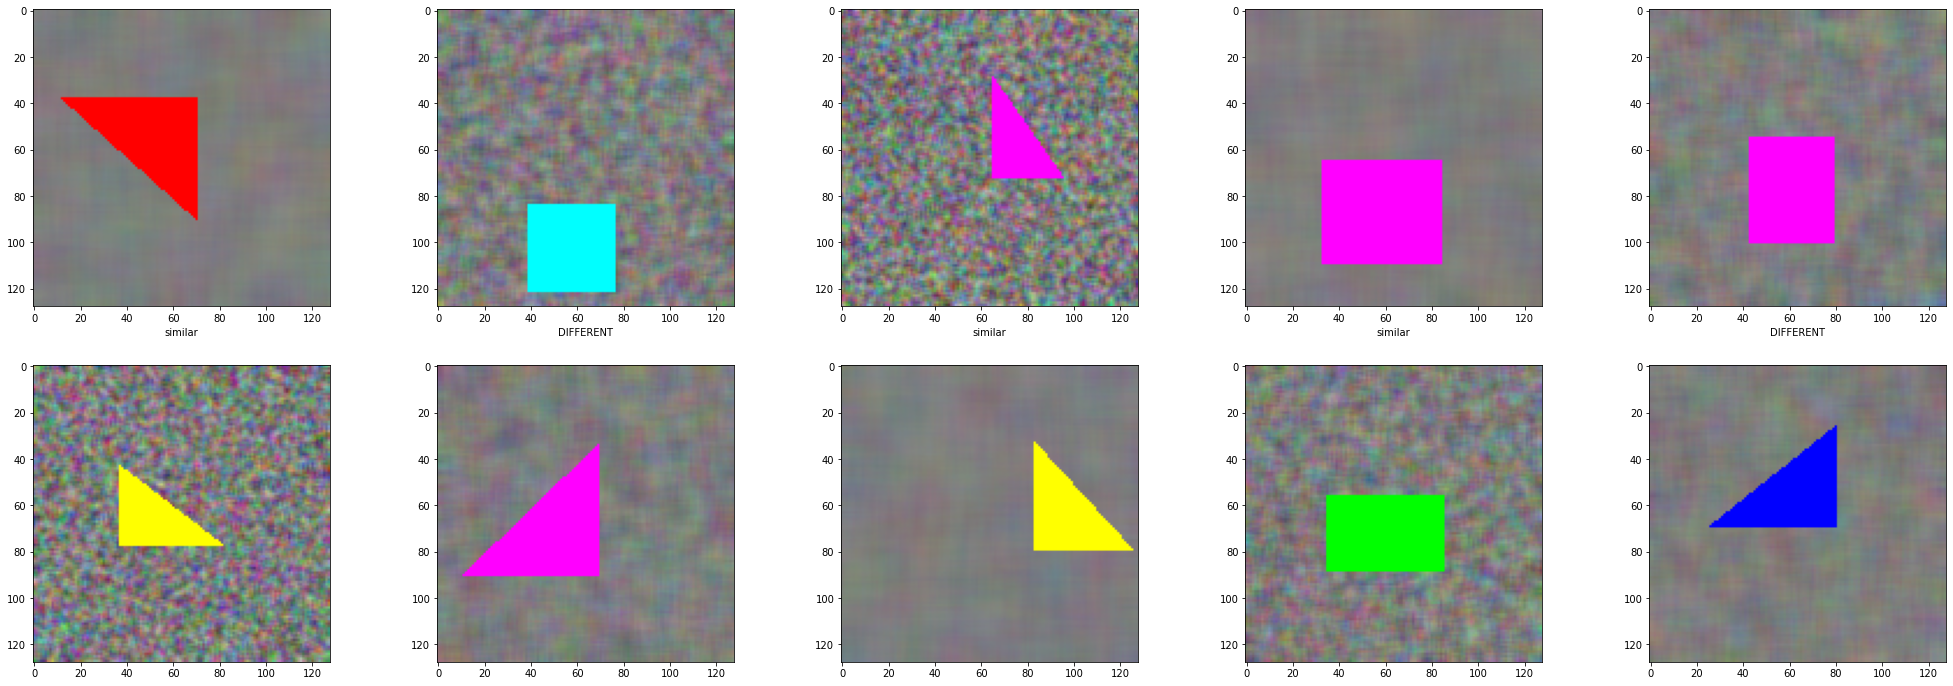

In [5]:
def plot_data(indx,imgarrl, imgarrr,imglabels):
    #plot image, plt keypoints
    plt.rcParams["figure.figsize"] = (35,12)

    def one_hot(val):
        if val == 1:
            return "similar"
        else:
            return "DIFFERENT"
    
    # draw a array of plots
    fig, axs = plt.subplots(2, len(imgarrl))
    for i in range(len(axs[0])):
        
        axs[0,i].set_xlabel(str(one_hot(imglabels[i][0])))
        axs[0,i].imshow(imgarrl[i])
        axs[1,i].imshow(imgarrr[i])

# draw n samples
tmp_data = train_data[0]

plot_data(None,tmp_data[0]['left_in'][:5], tmp_data[0]['right_in'][:5], tmp_data[1]['sia_out'][:5])

## Create a fuctional keras model

Inpus are:
- 2x image -  nx128x128x3

Output:
- similarity (probability) value, bigger is the better

Preprocess:
- before processing the image is normalized, this is done in the network (0,255)->(0,1)

## Create the layer to compar the distance between input pairs

Simple layer to compute de absolute value of the input difference

In [6]:
# create layer to calculate the distance between inputs
@tf.keras.utils.register_keras_serializable()
class Similaritylayer(keras.layers.Layer):
    def __init__(self,k=None,**kwargs):
        self.k = k
        super(Similaritylayer, self).__init__(**kwargs)
    
    def get_config(self):
        config = super().get_config()
        config["k"] = self.k
        return config
    
    def call(self, inputs):
        return keras.backend.abs(inputs[0]-inputs[1])
       

## Create the siamese network

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_in (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
right_in (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
left (Model)                    (None, 128)          195968      left_in[0][0]                    
__________________________________________________________________________________________________
right (Model)                   (None, 128)          195968      right_in[0][0]                   
______________________________________________________________________________________________

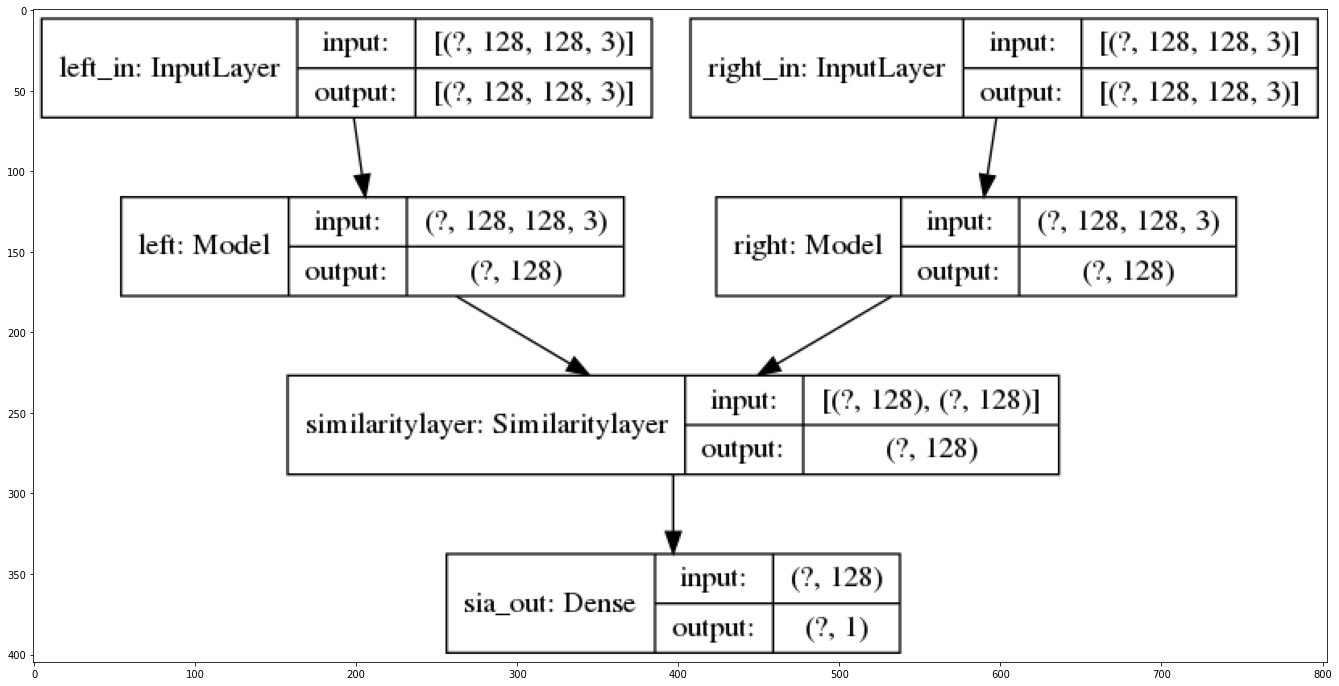

In [7]:
def create_model(model_name):
    # create the DNN functinal model
    image_in = keras.layers.Input(shape=(w,h,3), name="input_" + model_name)
    
    xhp = keras.layers.Lambda(lambda x: x/255.)(image_in)

    xhp = keras.layers.Conv2D(32,(10,10)) (xhp)
    xhp = keras.layers.BatchNormalization()(xhp)
    xhp = keras.layers.Activation('relu')(xhp)
    xhp = keras.layers.MaxPool2D(2,2)(xhp)

    
    xhp = keras.layers.Conv2D(64,(3,3)) (xhp)
    xhp = keras.layers.BatchNormalization()(xhp)
    xhp = keras.layers.Activation('relu')(xhp)
    xhp = keras.layers.MaxPool2D(2,2)(xhp)
    
    xhp = keras.layers.Conv2D(64,(3,3)) (xhp)
    xhp = keras.layers.BatchNormalization()(xhp)
    xhp = keras.layers.Activation('relu')(xhp)
    xhp = keras.layers.MaxPool2D(2,2)(xhp)
    
    xhp = keras.layers.Conv2D(128,(2,2)) (xhp)
    xhp = keras.layers.BatchNormalization()(xhp)
    xhp = keras.layers.Activation('relu')(xhp)
    xhp = keras.layers.MaxPool2D(2,2)(xhp)

    
    xhp = keras.layers.Conv2D(64,(3,3)) (xhp)
    xhp = keras.layers.BatchNormalization()(xhp)
    xhp = keras.layers.Activation('relu')(xhp)
    xhp = keras.layers.MaxPool2D(2,2)(xhp)

    
    xhp = keras.layers.Conv2D(32,(3,3), padding="same") (xhp)
    xhp = keras.layers.BatchNormalization()(xhp)
    xhp = keras.layers.Activation('relu')(xhp)
    xhp = keras.layers.MaxPool2D(2,2,padding="same")(xhp)


    xhp = keras.layers.Flatten()(xhp)
    
    out = keras.layers.Dense(128,activation='relu', name="out_" + model_name)(xhp)
    
    return keras.Model(inputs=image_in, outputs=out, name=model_name)


def create_siamese_model():

    # create the inputs
    input_left = keras.layers.Input(shape=(w,h,3), name="left_in")
    input_right = keras.layers.Input(shape=(w,h,3), name="right_in")
    
    # create 2 similar models
    left_model = create_model("left")(input_left)
    right_model = create_model("right")(input_right)
    
    # apply distance layer
    sia_layer = Similaritylayer()
    sim_dist = sia_layer([left_model,right_model])
        
    # add final layer
    sia_out = keras.layers.Dense(1, activation='sigmoid', name='sia_out')(sim_dist)
    
    return keras.Model(inputs=[input_left,input_right], outputs=sia_out)
    


    
sia_model = create_siamese_model()
keras.utils.plot_model(sia_model,to_file='./info/siamese_model.png',show_shapes=True)

sia_model.compile(keras.optimizers.Adam(1e-4),loss = keras.losses.BinaryCrossentropy(), metrics=['mae','acc'])


print (sia_model.summary())
img = plt.imread('./info/siamese_model.png')
plt.imshow(img)


## Train the model

In [8]:
epochs=50
steps=(samples//epochs)
valsteps= int(samples*0.1//epochs)

callbacks = [
    keras.callbacks.EarlyStopping(patience=7),
    keras.callbacks.ModelCheckpoint(filepath='model.h5',save_best_only=True,verbose=1),
]

hist = sia_model.fit(x=train_data,validation_data = tst_data,steps_per_epoch=steps,validation_steps=valsteps, epochs=epochs, batch_size=8,callbacks=callbacks, verbose=1,shuffle=False)

Epoch 1/50
199/200 [============================>.] - ETA: 0s - loss: 0.7178 - mae: 0.4978 - acc: 0.5107
Epoch 00001: val_loss improved from inf to 0.68598, saving model to model.h5
200/200 [==============================] - 10s 49ms/step - loss: 0.7177 - mae: 0.4977 - acc: 0.5113 - val_loss: 0.6860 - val_mae: 0.4958 - val_acc: 0.5500
Epoch 2/50
199/200 [============================>.] - ETA: 0s - loss: 0.7110 - mae: 0.4992 - acc: 0.5107
Epoch 00002: val_loss did not improve from 0.68598
200/200 [==============================] - 9s 47ms/step - loss: 0.7111 - mae: 0.4993 - acc: 0.5106 - val_loss: 0.7020 - val_mae: 0.5008 - val_acc: 0.4563
Epoch 3/50
199/200 [============================>.] - ETA: 0s - loss: 0.7059 - mae: 0.4976 - acc: 0.5094
Epoch 00003: val_loss did not improve from 0.68598
200/200 [==============================] - 9s 47ms/step - loss: 0.7060 - mae: 0.4976 - acc: 0.5094 - val_loss: 0.6955 - val_mae: 0.4953 - val_acc: 0.5125
Epoch 4/50
199/200 [=======================

Epoch 27/50
200/200 [==============================] - ETA: 0s - loss: 0.4032 - mae: 0.2813 - acc: 0.7981
Epoch 00027: val_loss did not improve from 0.33295
200/200 [==============================] - 9s 47ms/step - loss: 0.4032 - mae: 0.2813 - acc: 0.7981 - val_loss: 0.3387 - val_mae: 0.2328 - val_acc: 0.8500
Epoch 28/50
200/200 [==============================] - ETA: 0s - loss: 0.3733 - mae: 0.2604 - acc: 0.8131
Epoch 00028: val_loss did not improve from 0.33295
200/200 [==============================] - 10s 48ms/step - loss: 0.3733 - mae: 0.2604 - acc: 0.8131 - val_loss: 0.3964 - val_mae: 0.2708 - val_acc: 0.8062
Epoch 29/50
199/200 [============================>.] - ETA: 0s - loss: 0.3709 - mae: 0.2570 - acc: 0.8141
Epoch 00029: val_loss did not improve from 0.33295
200/200 [==============================] - 10s 48ms/step - loss: 0.3706 - mae: 0.2567 - acc: 0.8138 - val_loss: 0.3508 - val_mae: 0.2424 - val_acc: 0.7875
Epoch 30/50
199/200 [============================>.] - ETA: 0s - 


## Plot train information

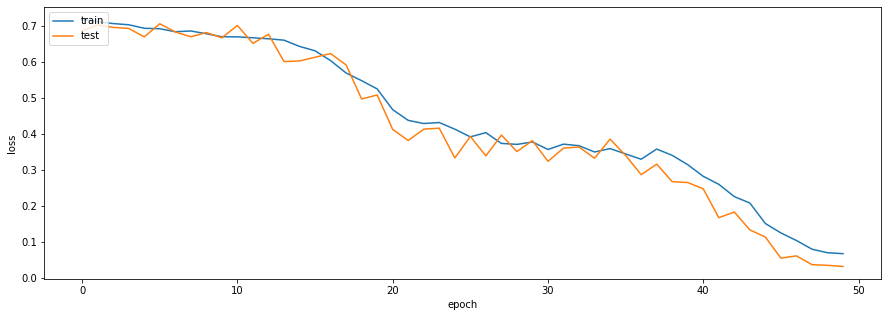

In [9]:
fig,axs = plt.subplots(figsize=(15, 5))
axs.set_xlabel("epoch")
axs.set_ylabel("loss")
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.legend(['train','test'], loc='upper left')

plt.show()


## Test the trained model

In [10]:
# load trained model
model = keras.models.load_model('model.h5')

tst_nr = 5
tst_imgsl,tst_imgsr,tst_labels = gen_traning_data(samples_nr=tst_nr,iw=w,ih=h,obj_min=obj_min_size,obj_max=obj_max_size)


# normalize images
tst_Xl = (tst_imgsl.reshape(tst_nr,-1))
tst_Xr = (tst_imgsr.reshape(tst_nr,-1))

tst_Xl = tst_Xl.reshape(len(tst_Xl),128,128,3)
tst_Xr = tst_Xr.reshape(len(tst_Xr),128,128,3)


# evaluate the model
print("Model performace on test data...\n")
results = model.evaluate(x={'left_in':tst_Xl, 'right_in':tst_Xr},y={'sia_out':tst_labels}, batch_size=1)
print("test loss, test acc:", results, "\n")

Model performace on test data...

5/5 [==============================] - 0s 4ms/step - loss: 0.2346 - mean_absolute_error: 0.1500 - acc: 0.8000
test loss, test acc: [0.23455047607421875, 0.1499997228384018, 0.800000011920929] 



## Compare reference data, print similarity

The model output is the probability for similarity, bigger is better.
A **threshold** value define the minimal accepted similarity, adjust if needed.

- the reference (**compare**) image is a sample newer seen by the model
- the samples (from the **compare_list**) should come from the training database

>Note: for this example the data generator generates a new random image for everry call, but is good enough to test the basic idea

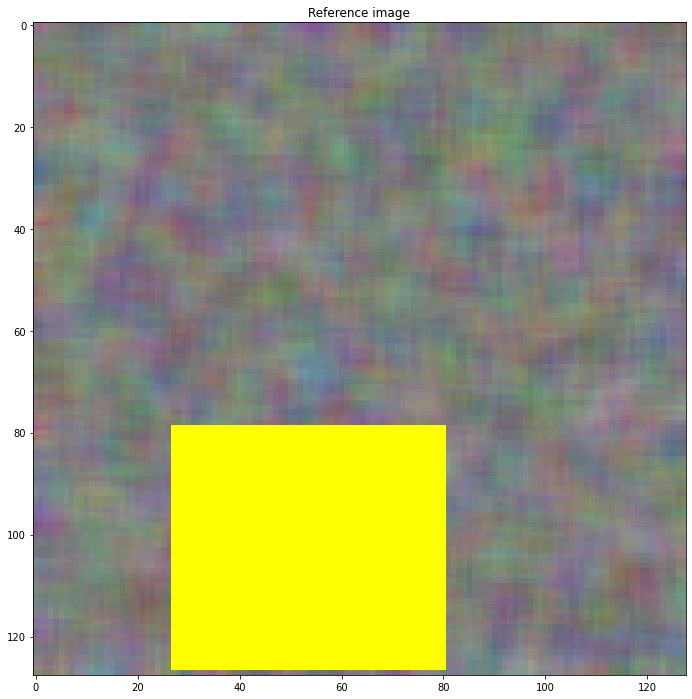

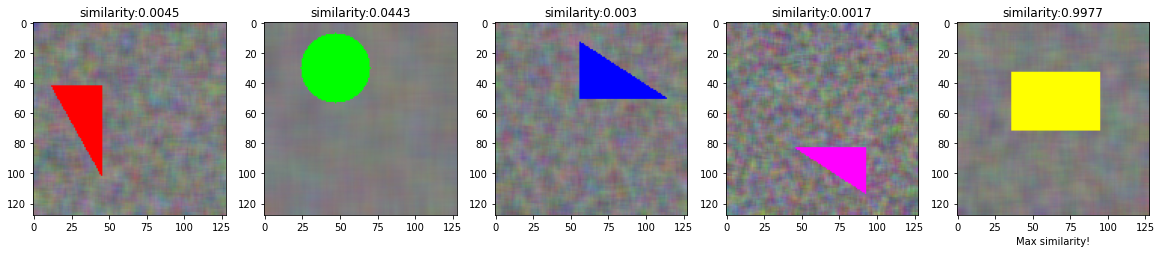

In [43]:
# generate inputs
threshold = 0.6 # minimal probabilty accepted for similarity

compare_list = []
shapes = ["circle","rectange","triangle"]

# generate n samples to be compared with the reference
for i in range (5):
    img = np.zeros(shape=(128,128,3),dtype=np.uint8)
    
    img = generate_blur(img)
        
    # generate random between [0,5]
    clord = np.random.randint(0,6,dtype=np.uint8)
    color = colors[clord]
    
    s_type = np.random.randint(0,3,dtype=np.uint8)
    
    shape = generate_img_with_shape(img,shape_type=s_type, color=color)

    compare_list.append({"shape":s_type, "val": shape})


# create the compare image, and show
img = np.zeros(shape=(128,128,3),dtype=np.uint8)
img = generate_blur(img)

stype = np.random.randint(0,3,dtype=np.uint8)
color = colors[clord]

compare = generate_img_with_shape(img,shape_type=stype, color=color)

plt.imshow(compare)
plt.title('Reference image')
plt.show()

# compare reference with other images
ret_list = []
fig, axs = plt.subplots(ncols=len(compare_list),figsize=(20, 15))
for i,k in enumerate(compare_list):
    
    limg = k['val']
    compare = compare
    
    # compare
    res = model.predict(x={'left_in':np.array([compare]), 'right_in':np.array([limg])}, batch_size=1)
    ret_list.append([res[0][0],k['shape']])
    
    #axs[i].imshow(k['val'])
    axs[i].imshow(limg)
    axs[i].set_title("similarity:" + str(np.round(res[0][0],4)))

# search for the max value
ret_val = np.argmax(np.array(ret_list), axis=0)

if ret_list[ret_val[0]][0]>= threshold:
    axs[ret_val[0]].set_xlabel("Max similarity!")
else:
    [axs[i].set_xlabel("NO similarity!") for i in range(len(compare_list))]


### References
1. [Siamese Neural Networks for One-shot Image Recognition, G Koch et al](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf)
2. [Few-Shot Learning with Siamese Networks and Label Tuning T Muller arXiv:2203.14655 [cs.CL]](https://doi.org/10.48550/arXiv.2203.14655)